In [310]:
import sys
import urllib.request
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import models,layers



In [311]:
'''如果本地没有数据集，则从服务器上拉取'''
filePath='./data/titanic.xls'
url = 'http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.xls'
if not os.path.isfile(filePath):
    result=urllib.request.urlretrieve(url,filePath)
    print('success download:'+result)
print('data input success')

data input success


In [303]:
excel=pd.read_excel(filePath)

dftrain_raw=excel[0:1000]
dftest_raw=excel[1000:]
print(dftest_raw.head(5))
cols=[
    'pclass','survived','name',	'sex','age','sibsp',
    'parch','ticket','fare','cabin','embarked',	
    'boat',	'body',	'home.dest'
]
print(dftrain_raw.head(5))

      pclass  survived                            name     sex  age  sibsp  \
1000       3         1    McCormack, Mr. Thomas Joseph    male  NaN      0   
1001       3         1              McCoy, Miss. Agnes  female  NaN      2   
1002       3         1             McCoy, Miss. Alicia  female  NaN      2   
1003       3         1              McCoy, Mr. Bernard    male  NaN      2   
1004       3         1  McDermott, Miss. Brigdet Delia  female  NaN      0   

      parch  ticket     fare cabin embarked boat  body home.dest  
1000      0  367228   7.7500   NaN        Q  NaN   NaN       NaN  
1001      0  367226  23.2500   NaN        Q   16   NaN       NaN  
1002      0  367226  23.2500   NaN        Q   16   NaN       NaN  
1003      0  367226  23.2500   NaN        Q   16   NaN       NaN  
1004      0  330932   7.7875   NaN        Q   13   NaN       NaN  
   pclass  survived                                             name     sex  \
0       1         1                    Allen, Mis

In [304]:
dftrain_raw=dftrain_raw.drop(['name','ticket'],axis=1)#丢弃 ‘ticket’这一列

#print(dftrain_raw.head(5))

pclass         0
survived       0
sex            0
age          139
sibsp          0
parch          0
fare           0
cabin        717
embarked       2
boat         583
body         905
home.dest    258
dtype: int64
0    577
1    423
Name: survived, dtype: int64


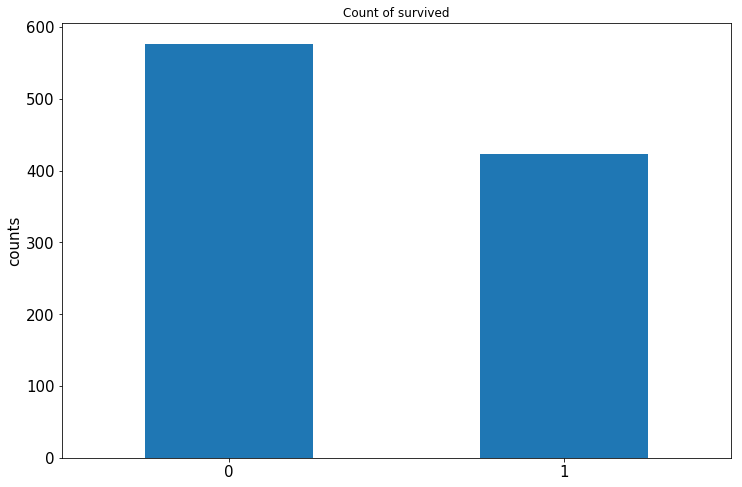

In [305]:
print(dftrain_raw.isnull().sum())#每一列中的空cell的个数
print(dftrain_raw['survived'].value_counts())
draft=dftrain_raw['survived'].value_counts().plot(kind = 'bar',
     figsize = (12,8),fontsize=15,rot = 0)
draft.set_title('Count of survived')
draft.set_ylabel('counts',fontsize=15)
plt.show()

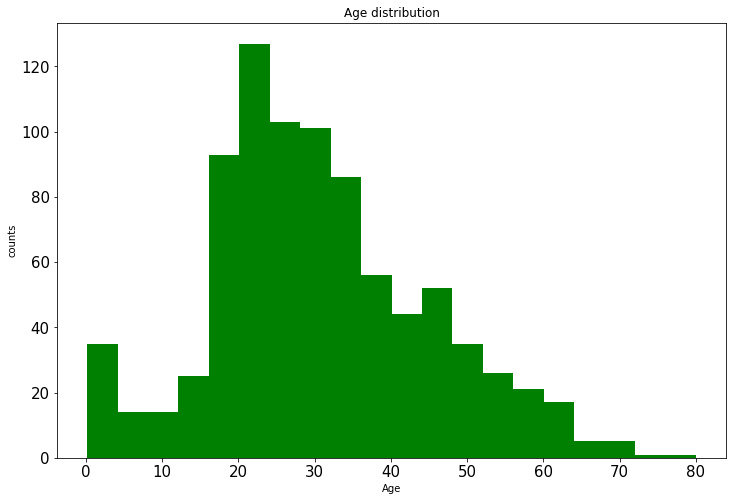

In [306]:
draft=dftrain_raw['age'].plot(
    kind='hist',figsize=(12,8),bins=20,color='green',
    fontsize=15,rot=0)
draft.set_title('Age distribution')
draft.set_ylabel('counts')
draft.set_xlabel('Age')
plt.show()

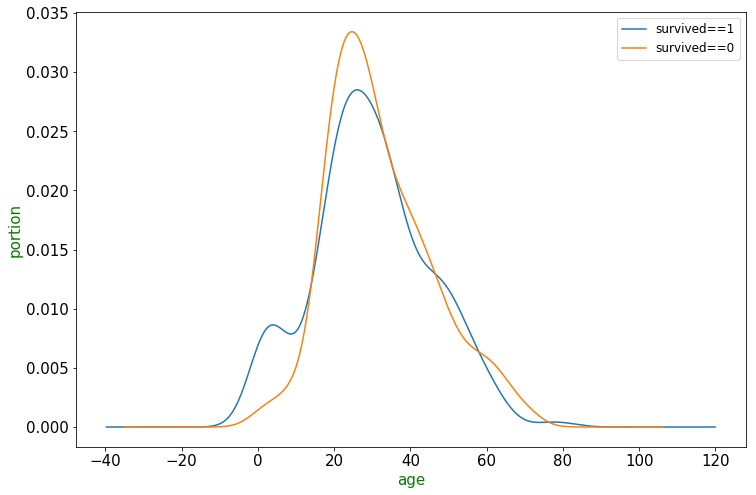

Age distribution of survived and not survived


In [307]:
#把存活的人的age全部获取，把序列画在图（age_sur_die）上,在图中画出存活者年龄分布的密度（占比）
#dftrain_raw.query('survived==1')['age']#查询符合条件‘survived==1’的年龄，返回的是一个一维序列
age_sur_die=dftrain_raw.query('survived==1')['age'].plot(
    kind='density',figsize=(12,8),fontsize=15)
dftrain_raw.query('survived==0')['age'].plot(
    kind='density',figsize=(12,8),fontsize=15)
age_sur_die.set_xlabel('age',fontsize=15,color='green')
age_sur_die.set_ylabel('portion',fontsize=15,color='green')
age_sur_die.legend(['survived==1','survived==0'],fontsize = 12)
plt.show()
print('Age distribution of survived and not survived')


In [315]:
def process(dfdata):
    dfresult=pd.DataFrame()
    '''数据的二值化'''
    #dfPclass
    #dfPclass=pd.DataFrame()
    print(pd.get_dummies(dfdata['pclass']))
    dfPclass=pd.get_dummies(dfdata['pclass'])
    print(dfPclass.shape)
    print(dfPclass.shape[1])
    tempdfpclass=pd.DataFrame(data={'A':[],'B':[]})
    if dfPclass.shape[1]<pd.get_dummies(excel['pclass']).shape[1]:
       i=1
       while i<pd.get_dummies(excel['pclass']).shape[1]-dfPclass.shape[1]-1 :
           tempdfpclass=pd.concat([tempdfpclass,tempdfpclass],axis=1)
           i=i+1
       dfPclass=pd.concat([tempdfpclass,dfPclass],axis=1)
    print(tempdfpclass.shape)
    
    dfPclass.columns = ['pclass_' +str(x) for x in  pd.get_dummies(excel['pclass']).columns]
    dfresult = pd.concat([dfresult,dfPclass],axis = 1)
    dfresult['pclass_1']=dfresult['pclass_1'].fillna(0)
    dfresult['pclass_2']=dfresult['pclass_2'].fillna(0)
    print(dfresult)
    #sex
    dfsex=pd.get_dummies(dfdata['sex'])
    #dfresult=pd.concat([dfresult,dfsex],axis=0)#frame的上下拼接
    dfresult=pd.concat([dfresult,dfsex],axis=1)#frame的左右拼接
    
    #Age #年龄特征为int32（从源frame中复制过来）若为空的默认填0，
    dfresult['age']=dfdata['age'].fillna(0)
    dfresult['age_null']=dfdata['age'].isnull().astype('int32')
    
     #SibSp,Parch,Fare
    dfresult['sibsp'] = dfdata['sibsp']
    dfresult['parch'] = dfdata['parch']
    dfresult['fare'] = dfdata['fare']

    #carbin
    #添加“所在船舱是否缺失”作为特征
    dfresult['cabin_null']=pd.isnull(dfdata['cabin']).astype('int32')
    
    #embarked
    dfembarked=pd.get_dummies(dfdata['embarked'],dummy_na=True)
    dfembarked.columns=['embark_'+str(x) for x in dfembarked.columns]
    dfresult=pd.concat([dfresult,dfembarked],axis=1)
    return (dfresult)

In [316]:
x_train=process(dftrain_raw)
y_train=dftrain_raw['survived'].values

x_test=process(dftest_raw)
y_test=dftest_raw['survived'].values

print("x_train.shape =", x_train.shape )
print("x_test.shape =", x_test.shape )

#print(x_train)
#print(x_test)
#print(excel)

     1  2  3
0    1  0  0
1    1  0  0
2    1  0  0
3    1  0  0
4    1  0  0
5    1  0  0
6    1  0  0
7    1  0  0
8    1  0  0
9    1  0  0
10   1  0  0
11   1  0  0
12   1  0  0
13   1  0  0
14   1  0  0
15   1  0  0
16   1  0  0
17   1  0  0
18   1  0  0
19   1  0  0
20   1  0  0
21   1  0  0
22   1  0  0
23   1  0  0
24   1  0  0
25   1  0  0
26   1  0  0
27   1  0  0
28   1  0  0
29   1  0  0
..  .. .. ..
970  0  0  1
971  0  0  1
972  0  0  1
973  0  0  1
974  0  0  1
975  0  0  1
976  0  0  1
977  0  0  1
978  0  0  1
979  0  0  1
980  0  0  1
981  0  0  1
982  0  0  1
983  0  0  1
984  0  0  1
985  0  0  1
986  0  0  1
987  0  0  1
988  0  0  1
989  0  0  1
990  0  0  1
991  0  0  1
992  0  0  1
993  0  0  1
994  0  0  1
995  0  0  1
996  0  0  1
997  0  0  1
998  0  0  1
999  0  0  1

[1000 rows x 3 columns]
(1000, 3)
3
(0, 2)
     pclass_1  pclass_2  pclass_3
0           1         0         0
1           1         0         0
2           1         0         0
3           1 